- Noms: Adriana Avilés, Anna Garcia, David Morillo, Paula Franco

- NIUs: 1676127, 1665817, 1666540, 1674234

# Restauració d'un soroll periòdic
Els passos que seguirem en aquest exercici son els següents:
1. Afagirem dos tipus de sorolls diferents en la mateixa imatge.
2. Veurem les seves transformades de Fourier.
3. Aplicarem el algorisme de Noch
4. Visualitzarem el resultat

### Importem les llibreries necessaries

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import skimage.io

### Aquesta és la imatge que farem servir en aquesta pràctica
La hem agafat del primer laboratori.

In [83]:
def display_gray_256(img): 
    plt.axis('off')
    plt.imshow(img, cmap = "gray", vmin = 0, vmax = 255)

Dimencions de la imatge: (256, 256)


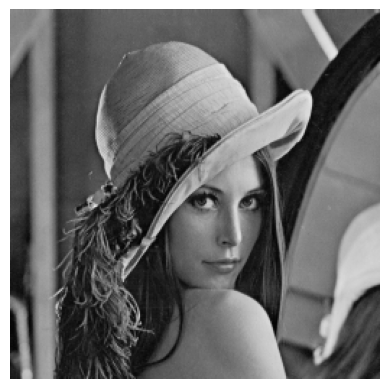

In [84]:
imatge = skimage.io.imread('https://www.eecs.northwestern.edu/~faisal/d20/lena.tif')
print("Dimencions de la imatge:", imatge.shape)
display_gray_256(imatge)

### Funcions que generen soroll
Les podeu fer servir per experimentar i veure diferents tipus de sorolls periòdics.

In [85]:
def Soroll_sinusoidal(alcada, amplada, amplitud, frequencia):
    x = np.linspace(0, amplada-1, amplada)
    y = np.linspace(0, alcada-1, alcada)
    X, Y = np.meshgrid(x, y)
    soroll_sinusoidal = amplitud * np.sin(2 * np.pi * frequencia * X) + amplitud * np.sin(2 * np.pi * frequencia * Y)
    return soroll_sinusoidal

def Soroll_sinusoidal_horitzontal(alcada, amplada, amplitud, frequencia):
    y = np.linspace(0, alcada-1, alcada)
    _, Y = np.meshgrid(np.zeros(alcada), y)
    soroll_horitzontal = amplitud * np.sin(2 * np.pi * frequencia * Y)
    return soroll_horitzontal

def Soroll_sinusoidal_vertical(alcada, amplada, amplitud, frequencia):
    x = np.linspace(0, amplada-1, amplada)
    X, _ = np.meshgrid(x, np.zeros(amplada))
    soroll_veritcal = amplitud * np.sin(2 * np.pi * frequencia * X)
    return soroll_veritcal
    
def Soroll_dents_de_serra(alcada, amplada, amplitud, frequencia):
    x = np.linspace(0, amplada-1, amplada)
    y = np.linspace(0, alcada-1, alcada)
    X, Y = np.meshgrid(x, y)
    soroll_dents_de_serra = amplitud * (2 * (X * frequencia - np.floor(X * frequencia + 0.5)))
    return soroll_dents_de_serra

def Soroll_diagonal(alcada, amplada, amplitud, frequencia):
    x = np.linspace(0, alcada-1, alcada)
    y = np.linspace(0, amplada-1, amplada)
    X, Y = np.meshgrid(x, y)
    soroll_diagonal = amplitud * np.sin(2 * np.pi * frequencia * (X + Y))
    return soroll_diagonal

### Laboratori
La següent cel·la serveix perquè experimenteu amb la imatge, proveu diferents sorolls, amplituds i freqüències.

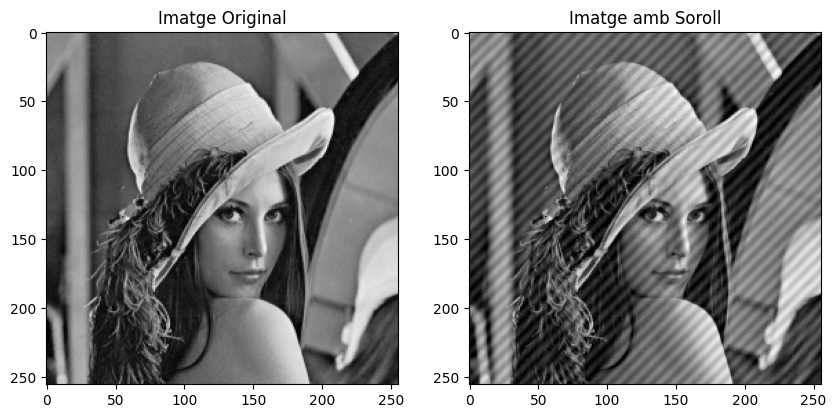

In [86]:
# Dimensions de la imatge
amplada, alcada = imatge.shape

# Paràmetres del soroll
amplitud = 20  # Amplitud del soroll
frequencia = 0.1  # Frequència del soroll

# Escollir el soroll
soroll = Soroll_diagonal(alcada, amplada, amplitud, frequencia) # Canviar la funcio del soroll per aplicar altres sorolls
#print(soroll)

# Aplicar el soroll a la imatge original
imatge_contaminada = imatge + soroll

# Limitar els valors a l'interval [0, 255]
imatge_contaminada = np.clip(imatge_contaminada, 0, 255)

# Mostrar la imatge original i la imatge amb soroll
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imatge, cmap='gray')
plt.title('Imatge Original')
plt.subplot(1, 2, 2)
plt.imshow(imatge_contaminada, cmap='gray')
plt.title('Imatge amb Soroll')
plt.show()



### Exemple
A continuació farem un exemple guiat perquè veieu pas a pas com funciona la restauració. Per el exemple utilitzarem el soroll sinusoidal horitzonral.

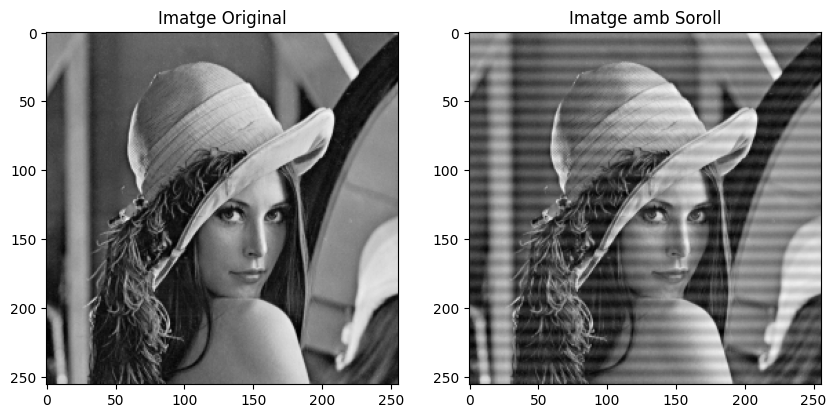

In [87]:
# Inicialització de les variables necessaries
amplada, alcada = imatge.shape
amplitud = 20
frequencia = 0.1
soroll = Soroll_sinusoidal_horitzontal(alcada, amplada, amplitud, frequencia)
imatge_contaminada = imatge + soroll

#Comprovem que tot estigui correcte
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(imatge, cmap='gray')
plt.title('Imatge Original')
plt.subplot(1, 2, 2)
plt.imshow(imatge_contaminada, cmap='gray')
plt.title('Imatge amb Soroll')
plt.show()

### Transformada de Fourier
A continuació, la funcio per calcular la transformada de Fourier.

In [88]:
def Fourier(imatge):
    fourier_transform = np.fft.fft2(imatge)
    fourier_transform_shifted = np.fft.fftshift(fourier_transform)
    magnitude_spectrum = 20 * np.log(np.abs(fourier_transform_shifted))
    return fourier_transform_shifted, magnitude_spectrum

# La funció retorna dues matrius, la primera és sobre la que aplicarem el filtre (fourier_transform_shifted) 
# i la segona la que utilitzarem per visuañitzar-la

### Identificar les diferencies
Ara visualitzem les dues transformades i identifiquem les diferencies. Així sabrem els canvis en les freqüències que haurem de eliminar.

Text(0.5, 1.0, 'Imatge contaminada')

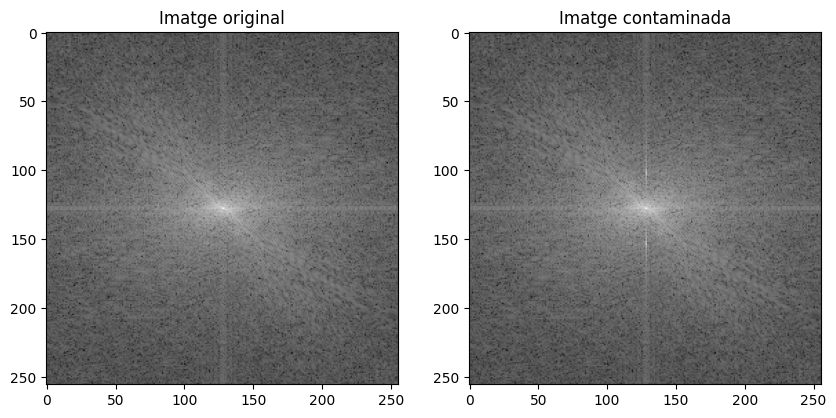

In [89]:
original_frequencies, original_visual = Fourier(imatge)
contaminada_frequencies, contaminada_visual = Fourier(imatge_contaminada)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(original_visual, cmap='gray')
plt.title('Imatge original')
plt.subplot(1, 2, 2)
plt.imshow(contaminada_visual, cmap='gray')
plt.title('Imatge contaminada')

**Podem observar que han aparagut uns punts de llum verticalment en el centre**

### Creació del filtre Notch
En la pràctica no podem ser molt exactes identificant els punts de llum, pero ens podem aproximar amb el filtre. Per fer-ho crearem una matriu de uns de les dimencions de la imatge i assignarem zeros en les parts que volem eliminar.

Text(0.5, 1.0, 'Filtre de Notch Aplicat')

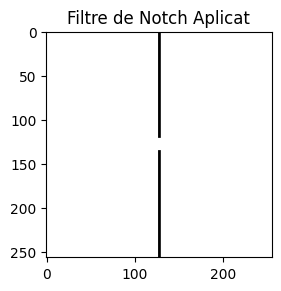

In [90]:
amplada, alcada = imatge.shape
notch_filter = np.ones((alcada, amplada))
for i in range(0, amplada): # Posem zeros en les tres columnes del mig sense contar el centre
    if i > 120 and i < 135:
        pass
    else:
        notch_filter[i][127] = 0 
        notch_filter[i][128] = 0 
        notch_filter[i][129] = 0 

# Visualizar el filtre que aplicarem
plt.subplot(1, 2, 2)
plt.imshow(notch_filter, cmap='gray')
plt.title('Filtre de Notch Aplicat')

### Apliquem el filtre

C:\Users\david\AppData\Local\Temp\ipykernel_21556\605157836.py:5: RuntimeWarning: divide by zero encountered in log
  filtrada_visual = 20 * np.log(np.abs(filtrada_frequencies))


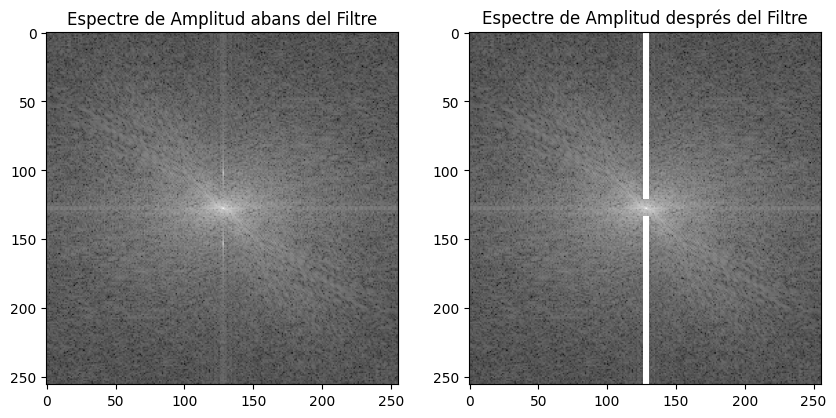

In [91]:
# Aplicar el filtre de notch multiplicant-lo a la transformada de Fourier
filtrada_frequencies = contaminada_frequencies * notch_filter

# Calcular el espectre d'amplitud després d'aplicar el filtre
filtrada_visual = 20 * np.log(np.abs(filtrada_frequencies))

# Visualitzar el espectre d'amplitud abans i després d'aplicar el filtre
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(contaminada_visual, cmap='gray')
plt.title('Espectre de Amplitud abans del Filtre')

plt.subplot(1, 2, 2)
plt.imshow(filtrada_visual, cmap='gray')
plt.title('Espectre de Amplitud després del Filtre')

plt.show()

**No sempre aconseguireu tapar la part necessaria a la primera ja que no podem ser del tot precisos amb aquestes eines, és important fer proves i assegurar-se de tapar-les.**

### Invertir Fourier
A continuació podeu veure el resultat final del procés

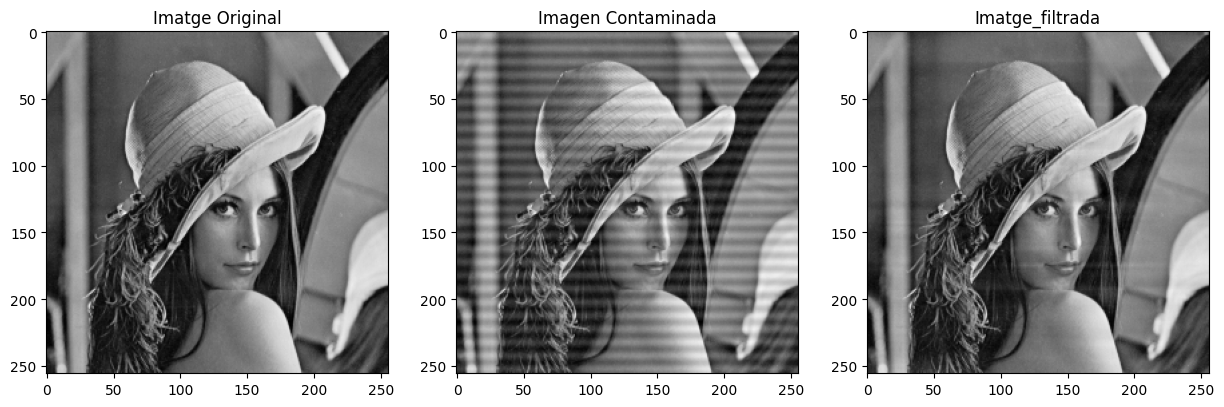

In [92]:
# Invertir el cambio de Fourier
imatge_filtrada = np.fft.ifft2(np.fft.ifftshift(filtrada_frequencies)).real

# Visualizar la imagen original y la imagen filtrada
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imatge, cmap='gray')
plt.title('Imatge Original')

plt.subplot(1, 3, 2)
plt.imshow(imatge_contaminada, cmap='gray')
plt.title('Imagen Contaminada')

plt.subplot(1, 3, 3)
plt.imshow(imatge_filtrada, cmap='gray')
plt.title('Imatge_filtrada')

plt.show()

### Exercici
A continuació us demanem que repetiu el procés però aplicant un altre tipus de soroll a la imatge, recomanem el soroll sinusoidal vertical ;).

C:\Users\david\AppData\Local\Temp\ipykernel_21556\2137868126.py:10: RuntimeWarning: divide by zero encountered in log
  filtrada_visual = 20 * np.log(np.abs(filtrada_frequencies))


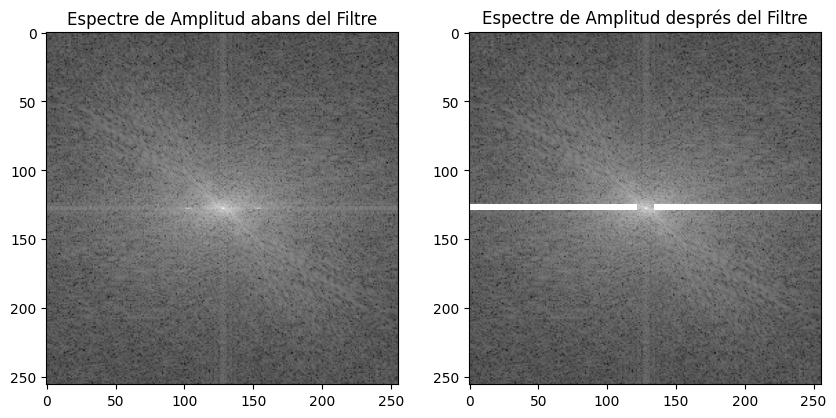

In [93]:
amplitud = 20
frequencia = 0.1
soroll = Soroll_sinusoidal_vertical(alcada, amplada, amplitud, frequencia)
imatge_contaminada = imatge + soroll

contaminada_frequencies, contaminada_visual = Fourier(imatge_contaminada)

notch_filter_rot90 = np.rot90(notch_filter)
filtrada_frequencies = contaminada_frequencies * notch_filter_rot90
filtrada_visual = 20 * np.log(np.abs(filtrada_frequencies))

# Visualitzar el espectre d'amplitud abans i després d'aplicar el filtre
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(contaminada_visual, cmap='gray')
plt.title('Espectre de Amplitud abans del Filtre')

plt.subplot(1, 2, 2)
plt.imshow(filtrada_visual, cmap='gray')
plt.title('Espectre de Amplitud després del Filtre')

plt.show()

Text(0.5, 1.0, 'Imatge_filtrada')

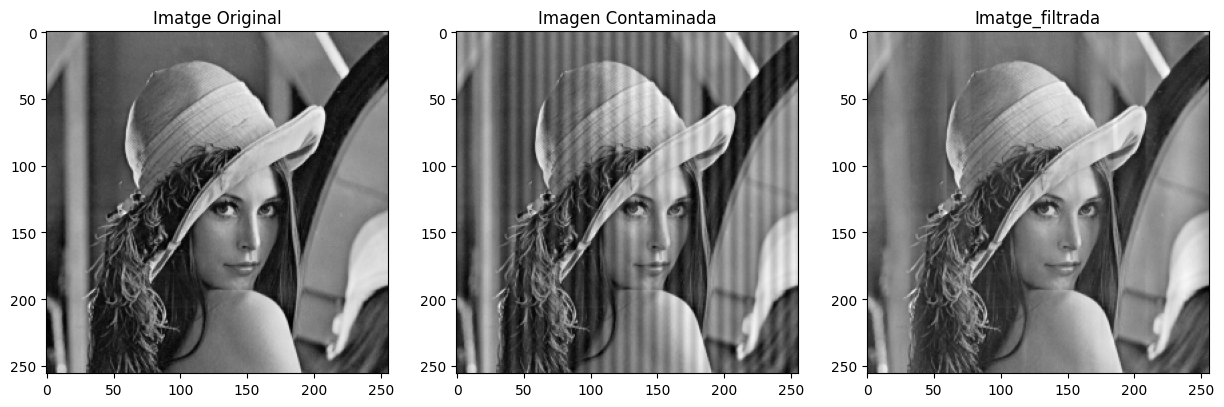

In [94]:
imatge_filtrada = np.fft.ifft2(np.fft.ifftshift(filtrada_frequencies)).real

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(imatge, cmap='gray')
plt.title('Imatge Original')

plt.subplot(1, 3, 2)
plt.imshow(imatge_contaminada, cmap='gray')
plt.title('Imagen Contaminada')

plt.subplot(1, 3, 3)
plt.imshow(imatge_filtrada, cmap='gray')
plt.title('Imatge_filtrada')

### Extra
Si voleu un exercici més complicat podeu probar de eliminar el soroll diagonal de la imatge.

C:\Users\david\AppData\Local\Temp\ipykernel_21556\2742879781.py:23: RuntimeWarning: divide by zero encountered in log
  filtrada_visual = 20 * np.log(np.abs(filtrada_frequencies))


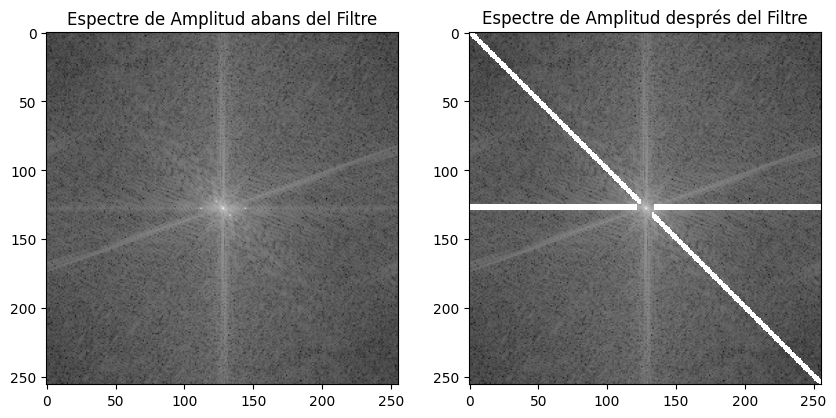

In [95]:
amplitud = 20
frequencia = 0.1

imatge_contaminada = skimage.io.imread("imatgefinal.jpg")
imatge_contaminada = skimage.transform.resize(imatge_contaminada, (256, 256), anti_aliasing=True)
amplada, alcada = imatge_contaminada.shape

contaminada_frequencies, contaminada_visual = Fourier(imatge_contaminada)

notch_filter_rot90 = np.rot90(notch_filter)

notch_filter_rot45 = np.ones((alcada, amplada))
width = 3
c = 3
for i in range(min(alcada, amplada)):
    for j in range(max(0, i - width // 2), min(amplada, i + width // 2 + 1)):
        if j + c < amplada // 2 - width // 2 or j - c > amplada // 2 + width // 2:
            notch_filter_rot45[i, j] = 0

notch_total = (notch_filter_rot45 + notch_filter_rot90)//2

filtrada_frequencies = contaminada_frequencies * notch_total
filtrada_visual = 20 * np.log(np.abs(filtrada_frequencies))

# Visualitzar el espectre d'amplitud abans i després d'aplicar el filtre
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(contaminada_visual, cmap='gray')
plt.title('Espectre de Amplitud abans del Filtre')

plt.subplot(1, 2, 2)
plt.imshow(filtrada_visual, cmap='gray')
plt.title('Espectre de Amplitud després del Filtre')

plt.show()

Text(0.5, 1.0, 'Imatge_filtrada')

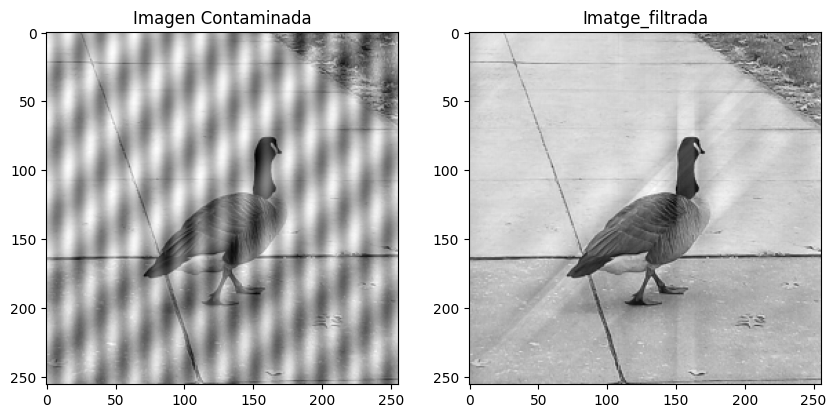

In [96]:
imatge_filtrada = np.fft.ifft2(np.fft.ifftshift(filtrada_frequencies)).real

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(imatge_contaminada, cmap='gray')
plt.title('Imagen Contaminada')

plt.subplot(1, 2, 2)
plt.imshow(imatge_filtrada, cmap='gray')
plt.title('Imatge_filtrada')